In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Thallapally Nimisha\
CS22B1082\
12.02.2025

# Binary Classification of Skin Lesions

#### Checking if GPU is available

In [21]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8935235491998552294
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5713690624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5301851482197498308
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


## LAB 4

In [22]:
train_dir='isic2020/train/'
test_dir='isic2020/test/'
train=pd.read_csv('isic2020/train.csv')
test=pd.read_csv('isic2020/test.csv')
# submission=pd.read_csv('skin_dataset/sample_submission.csv')

### EDA

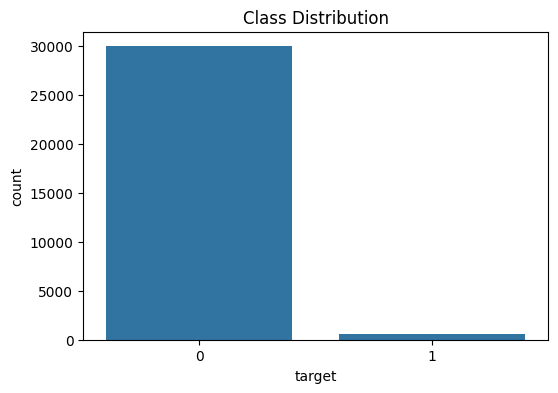

Class counts:
target
0    29978
1      541
Name: count, dtype: int64


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv('isic2020/train.csv')

# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df)
plt.title('Class Distribution')
plt.show()

# Print class counts
class_counts = df['target'].value_counts()
print("Class counts:")
print(class_counts)

In [24]:
# Check for missing values
print(df.isnull().sum())

image_name                         0
patient_id                         0
sex                               41
age_approx                        44
anatom_site_general_challenge    507
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64


### Undersampling as the data is unbalanced
Taking only 550 Benign samples out of 29978.

As the data is very imbalanced, I'll train on only a sample of it.

In [25]:
df_0=train[train['target']==0].sample(550)
df_1=train[train['target']==1]
train=pd.concat([df_0,df_1])
train=train.reset_index()

Benign Cases


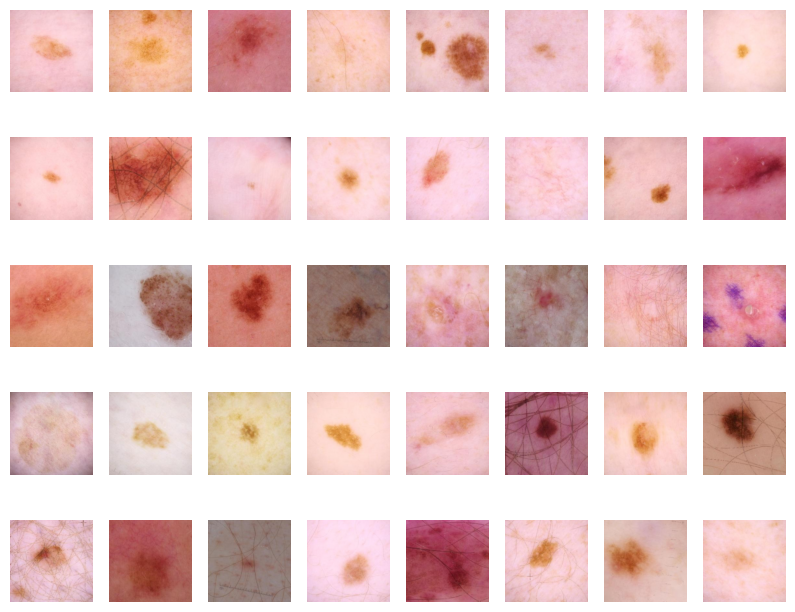

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

print('Benign Cases')
benign = []
df_benign = df_0.sample(40).reset_index()

for i in range(40):
    image_name = df_benign['image_name'].iloc[i] + '.jpg'
    found = False
    img_path = os.path.join(train_dir, image_name)
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            benign.append(img)
            found = True
            
    if not found:
        print(f"Image {image_name} not found in any training sub-directory.")

f, ax = plt.subplots(5, 8, figsize=(10, 8))
for i, img in enumerate(benign):
    ax[i // 8, i % 8].imshow(img)
    ax[i // 8, i % 8].axis('off')

plt.show()


Malignant Cases


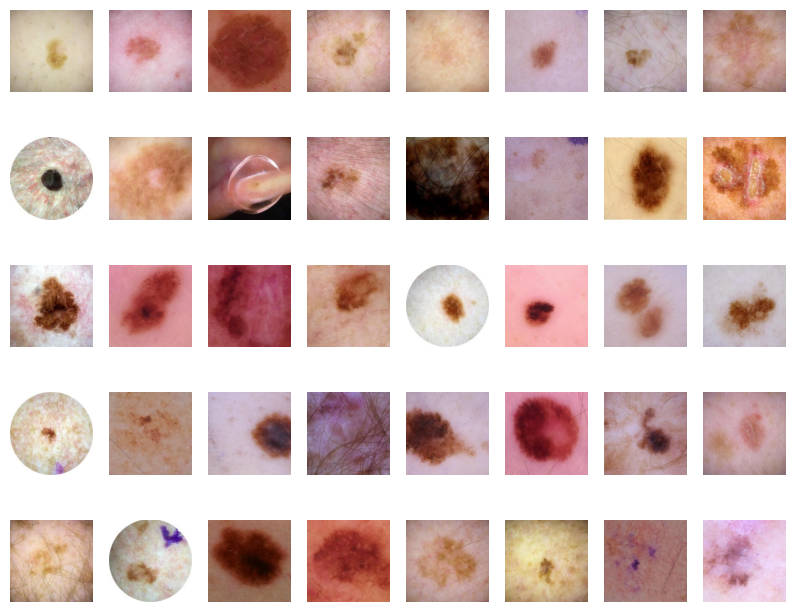

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

print('Malignant Cases')
malignant = []
df_malignant = df_1.sample(40).reset_index()

for i in range(40):
    image_name = df_malignant['image_name'].iloc[i] + '.jpg'
    found = False
    img_path = os.path.join(train_dir, image_name)
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            malignant.append(img)
            found = True

    if not found:
        print(f"Image {image_name} not found in any training sub-directory.")

f, ax = plt.subplots(5, 8, figsize=(10, 8))
for i, img in enumerate(malignant):
    ax[i // 8, i % 8].imshow(img)
    ax[i // 8, i % 8].axis('off')

plt.show()


### Dataset class

In [29]:
# Custom Dataset class
class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_name = row['image_name'] + '.jpg'
        label = row['target']

        image_path = os.path.join(self.root_dir, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)  # Convert to PIL Image

        if self.transform:
            image = self.transform(image)

        return image, label

### Transformations

In [30]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


### Load dataset and dataloader

In [31]:
from sklearn.model_selection import train_test_split

# Load balanced dataset
df = train.copy(deep=True)

# Split dataset into train and validation (80:20)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])

# # Save the splits if needed
# train_df.to_csv('skin_dataset/train_split.csv', index=False)
# val_df.to_csv('skin_dataset/val_split.csv', index=False)

In [43]:
train_dataset = SkinLesionDataset(train_df, root_dir=train_dir, transform=transform)
val_dataset = SkinLesionDataset(val_df, root_dir=train_dir, transform=transform)
test_dataset = SkinLesionDataset(test, root_dir=test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data loaders created successfully!")

Data loaders created successfully!


### Basic layers

In [33]:
class Bottleneck(nn.Module):
    expansion = 4  # Bottleneck expands output channels by 4x

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)  # 1x1 conv
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)  # 3x3 conv
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)  # 1x1 conv
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # Adjust dimensions if needed

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity  # Residual connection
        out = self.relu(out)
        return out


### ResNet-152 Model
The total number of layers in the **ResNet-152** implementation can be calculated as follows:

### Initial Layers:
- `Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)` → **1 layer**
- `BatchNorm2d(64)` → **1 layer**
- `ReLU(inplace=True)` → *(Not counted as a layer)*
- `MaxPool2d(kernel_size=3, stride=2, padding=1)` → *(Not counted as a layer)*

### Bottleneck Blocks (each has **3 Conv layers**):
- **layer1**: 3 Bottleneck blocks → **\(3 * 3 = 9\) layers**
- **layer2**: 8 Bottleneck blocks → **\(8 * 3 = 24\) layers**
- **layer3**: 36 Bottleneck blocks → **\(36 * 3 = 108\) layers**  
- **layer4**: 3 Bottleneck blocks → **\(3 * 3 = 9\) layers**

### Final Layers:
- `AdaptiveAvgPool2d((1, 1))` → *(Not counted as a layer)*
- `Linear(512 * Bottleneck.expansion, num_classes)` → **1 layer**

### Total Number of Layers:
\[
1 + 1 + (9 + 24 + 108 + 9) + 1 = 152
\]


In [34]:
class ResNet152(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet152, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Standard ResNet-152 Layer Structure
        self.layer1 = self._make_layer(64, 3)   # 3 Bottleneck blocks
        self.layer2 = self._make_layer(128, 8, stride=2)  # 8 Bottleneck blocks
        self.layer3 = self._make_layer(256, 36, stride=2) # 36 Bottleneck blocks
        self.layer4 = self._make_layer(512, 3, stride=2)  # 3 Bottleneck blocks

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)  # Fully connected layer

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * Bottleneck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * Bottleneck.expansion),
            )

        layers = []
        layers.append(Bottleneck(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * Bottleneck.expansion  # Update input channels

        for _ in range(1, blocks):
            layers.append(Bottleneck(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


### Initialize Model, Loss, Optimizer

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet152(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# criterion = nn.CrossEntropyLoss(label_smoothing=CFG['label_smooth_fac'])
# if CFG['optimizer'] == 'adam':
#     optimizer = optim.Adam(model.parameters(), lr=0.0001)
# elif CFG['optimizer'] == 'SGD':
#     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print("Model initialized and moved to device:", device)


Model initialized and moved to device: cuda


### Custom Model Architecture

In [16]:
print(model)

ResNet152(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

### Inbuilt Model Architecture

In [25]:
import torch
import torchvision.models as models

# Load the pre-trained ResNet152 model from torchvision
resnet152 = models.resnet152(weights=None)  # Load ResNet152 without pre-trained weights

# Print the model architecture
print(resnet152)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
import torch
import torchvision.models as models
from torchviz import make_dot

# Load the ResNet152 model from torchvision
resnet152 = models.resnet152(pretrained=False)

# Create a dummy input tensor (for example, a batch of images with size (1, 3, 224, 224))
dummy_input = torch.randn(1, 3, 224, 224)

# Perform a forward pass to get the computation graph
output = resnet152(dummy_input)

# Generate the visualization
dot = make_dot(output, params=dict(resnet152.named_parameters()))

# Save the diagram to a PNG file
dot.render("resnet152_architecture", format="png")


C:\Users\Ishank\anaconda3\envs\tfgpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ishank\anaconda3\envs\tfgpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.783206 to fit


'resnet152_architecture.png'

### Model Training

In [36]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch [1/10], Train Loss: 0.7397, Train Acc: 0.5998, Val Loss: 1.0152, Val Acc: 0.4977
Epoch [2/10], Train Loss: 0.5996, Train Acc: 0.6904, Val Loss: 0.6039, Val Acc: 0.6804
Epoch [3/10], Train Loss: 0.5577, Train Acc: 0.7007, Val Loss: 0.5694, Val Acc: 0.6849
Epoch [4/10], Train Loss: 0.5352, Train Acc: 0.7454, Val Loss: 0.5919, Val Acc: 0.7078
Epoch [5/10], Train Loss: 0.5387, Train Acc: 0.7248, Val Loss: 0.5878, Val Acc: 0.7032
Epoch [6/10], Train Loss: 0.5077, Train Acc: 0.7626, Val Loss: 0.6967, Val Acc: 0.6849
Epoch [7/10], Train Loss: 0.5118, Train Acc: 0.7626, Val Loss: 0.9079, Val Acc: 0.6758
Epoch [8/10], Train Loss: 0.5069, Train Acc: 0.7626, Val Loss: 0.7148, Val Acc: 0.6758
Epoch [9/10], Train Loss: 0.4946, Train Acc: 0.7569, Val Loss: 0.6011, Val Acc: 0.6895
Epoch [10/10], Train Loss: 0.4778, Train Acc: 0.7764, Val Loss: 0.5812, Val Acc: 0.7580


### Plotting

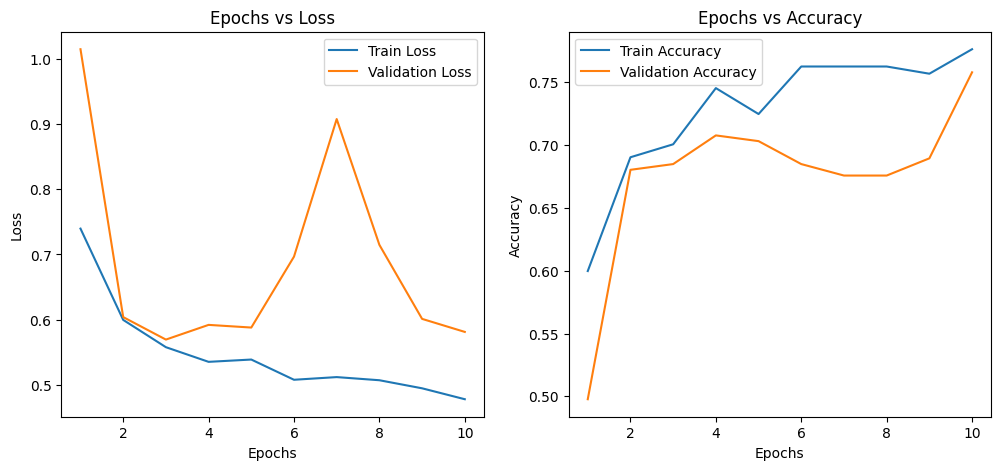

In [37]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.legend()

plt.show()

### Metrics calculation

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# After validation phase in each epoch

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='binary', zero_division=1)
recall = recall_score(all_labels, all_preds, average='binary', zero_division=1)
f1 = f1_score(all_labels, all_preds, average='binary')

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


Accuracy: 0.7580, Precision: 0.7121, Recall: 0.8624, F1-score: 0.7801


## Classification report

In [39]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.83      0.65      0.73       110
   Malignant       0.71      0.86      0.78       109

    accuracy                           0.76       219
   macro avg       0.77      0.76      0.76       219
weighted avg       0.77      0.76      0.76       219



In [41]:
# # Save the trained model
# torch.save(model.state_dict(), 'resnet152_isic2020-undersampling-1.pth')
# print("Model saved successfully ")

In [22]:
# model.load_state_dict(torch.load('resnet152_skin_lesion_model-undersampling-final.pth'))
# model.eval()  # Set the model to evaluation mode

### Prediction on test set

In [44]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    print("Test started.")
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    print("Test completed.")

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


Test started.
Test completed.
Accuracy: 0.6994, Precision: 0.0523, Recall: 0.9000, F1-score: 0.0989


In [45]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       1.00      0.70      0.82      2142
   Malignant       0.05      0.90      0.10        40

    accuracy                           0.70      2182
   macro avg       0.52      0.80      0.46      2182
weighted avg       0.98      0.70      0.81      2182



# Skin Lesion Classification using ResNet-152

## 1. Introduction
This report presents the implementation and evaluation of **ResNet-152**, for binary classification of skin lesions into **benign** and **malignant** categories. The model was built from scratch using **basic PyTorch layers** such as convolutional, linear, activation, and pooling layers, without relying on prebuilt architectures.

## 2. Dataset and Preprocessing
The dataset consists of images of skin lesions. 

Key preprocessing steps include:
- **Resizing images** to match the input size required by ResNet-152.
- **Normalization** to standardize pixel values.
- **Data augmentation** (flipping, rotation, and brightness adjustment) to enhance model generalization.

## 3. Model Architecture

The layer configuration of ResNet-152 is as follows:
- Initial convolutional layer with batch normalization and max pooling.
- Four main residual layers:
  - Layer 1: 3 residual blocks
  - Layer 2: 8 residual blocks
  - Layer 3: 36 residual blocks
  - Layer 4: 3 residual blocks
- Global average pooling layer.
- Fully connected layer for binary classification.

## 4. Hyperparameter Selection

- **Batch size**: The initial batch size was set to 8, which led to a **training accuracy of 98.4%** that remained constant. The test accuracy also showed no significant changes with different batch sizes.
- **Learning rate**: A lower learning rate was used to ensure stable convergence. Experiments with higher values led to unstable gradients.
- **Optimizer**: Adam optimizer was used for efficient weight updates.
- **Data augmentation**: Implementing data augmentation improved generalization.

## 5. Results and Observations

### Without Data Augmentation and Batch Size of 8:
- **Training Accuracy:** 98.4% (constant, not improving)
- **Test Accuracy:** 98.4% (not increasing or decreasing)

### With Data Augmentation:
- **Final Accuracy:** 97.93%
- **Precision:** 0.3333
- **Recall:** 0.1538
- **F1-score:** 0.2105

### Final Model Performance:
#### Training Metrics:
| Class      | Precision | Recall | F1-score | Support |
|------------|-----------|--------|---------|---------|
| Benign     | 0.83      | 0.65   | 0.73    | 110     |
| Malignant  | 0.71      | 0.86   | 0.78    | 109     |
| **Overall Accuracy** | **0.76** | - | - | 219 |

#### Testing Metrics:
| Class      | Precision | Recall | F1-score | Support |
|------------|-----------|--------|---------|---------|
| Benign     | 1.00      | 0.70   | 0.82    | 2142    |
| Malignant  | 0.05      | 0.90   | 0.10    | 40      |
| **Overall Accuracy** | **0.70** | - | - | 2182 |

## 6. Conclusion
- Training accuracy remained **constant at 98.4%** with batch size 8, indicating potential overfitting.
- Data augmentation improved generalization but lowered precision and recall for the malignant class.
- The final model achieved **70% accuracy** on the test set but struggled with malignant classification, having a recall of **90% but very low precision (0.05)**.
- Further improvements could be made by adjusting **class weights, data balancing techniques, and hyperparameter tuning**.
